# Building a Recommender System from Scratch

### What is a recommender?

### How do you build a recommender?

#### Collaborative Filtering

#### Content-based filtering

### Step 1: Import Dependencies

- Representing our dataset as a `pandas` dataframe
- Represneting our user-item matrix as a `scipy.sparse.csr_matrix`
- Visualizing data with `matplotlib` and `seaborn` (a matplotlib wrapper)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

Let's download a small version of the MovieLens dataset. See here for zip file url, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our repository:

- ratings.csv
- movies.csv

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

In [3]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [4]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Step 3: Exploratory Data Analysis

In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


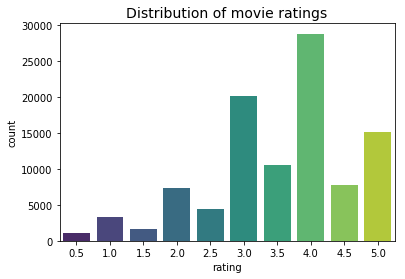

In [6]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

#### Best vs. Worst Movie

Which movie has the lowest and highest average rating?

In [61]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]


,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


`Santa with Muscles` has the lowest average rating.

In [72]:
highest_rated = mean_ratings['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


Lamerica may be the "highest" rated movie, but it only has one rating. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [64]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [65]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [69]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats = movie_stats.sort_values('bayesian_avg', ascending=False)
movie_stats.head()

,movieId,count,mean,bayesian_avg,title
284,318,311,4.487138,4.446203,"Shawshank Redemption, The (1994)"
695,858,200,4.487500,4.425014,"Godfather, The (1972)"
48,50,201,4.370647,4.314534,"Usual Suspects, The (1995)"
977,1221,135,4.385185,4.302614,"Godfather: Part II, The (1974)"
472,527,244,4.303279,4.259541,Schindler's List (1993)


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `The Usual Suspects` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [71]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2869,3593,19,1.210526,1.975099,Battlefield Earth (2000)
1242,1556,23,1.652174,2.183723,Speed 2: Cruise Control (1997)
2161,2701,47,2.031915,2.271446,Wild Wild West (1999)
489,546,17,1.735294,2.347912,Super Mario Bros. (1993)
1243,1562,47,2.148936,2.366224,Batman & Robin (1997)


With Bayesian average, it looks like `Battlefield Earth`, `Speed 2: Cruise Control` and `Wild Wild West` are the worst rated movies. `Santa with Muscles` isn't so bad after all.

### Part 2: Top N recommender

movies

In [42]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller
